# EDA and Adversarial Validation

In this notebook we'll perform a Simple Exploratory Data Analysis on the train dataset of this competition, look at how similar/dissimilar train and test data are using Adversarial Validation and in the end train a Simple XGBoost Model to make a submission. 

EDA is a very crucial step in the model building process as it allows us to get to know the data better. It helps in cleaning the data and engineering features for the model.

Let's Start!!!

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_log_error

 ### Data description:

* store_sales(in millions) - Store Sales(in million dollars)
* unit_sales(in millions) - Unit Sales(in millions) in Stores Quantity
* Total_children - Total Children in Home
* avg_cars_at home(approx) - Average Cars at home(approx)
* Num_children_at_home - Number of Children at Home as per Customer Filled Details
* Gross_weight - Gross Weight of the Item
* Recyclable_package - Whether Food Item is in a Recyclable Package or not
* Low_fat - Whether Food Item is Low Fat or not
* Units_per_case - Units Available in Each Store Shelves
* Store_sqft - Store Area In SQFT
* Coffee_bar - Whether Coffee Bar is available in store or not
* Video_store - Whether Gaming Store is available or not
* Salad_bar - Salad Bar available in store or not
* Prepared_food - Prepared Food available in store or not
* Florist - Flower shelves available in store or not
* Cost - Cost of Acquiring Customers in dollars

#### Our Task is to devise a Machine Learning Model that helps us predict the cost of media campaigns in the food marts on the basis of the features provided.

### Evalaution Metric for this Competition:

#### Root Mean Squared Log Error (RMLSE):
* The mean_squared_log_error function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.
* Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.
* We can use sklearn's mean_squared_log_error with squared=False for evaluating our models
* We can also transform the target variable by taking a log transformation to use RMSE as the evaluation metric and in the end transform the predictions of our model back by taking an anti-log. 

In [2]:
# Import Train Data and View the first five samples
df = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
print('Shape of Train Dataset:', df.shape)
print()
df.head()

Shape of Train Dataset: (360336, 17)



,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


#### Key Insights:
* In the train dataset, we have 360336 samples and 17 Variables. 
* Out of these 17 Variables, the id column is just an index column, so we can drop it while training our model and the cost column is the target variable. 
* So, there are 15 features that we can use to train our model.

In [3]:
# Import Test Data and View the first five samples
test_df = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
print('Shape of Test Dataset:', test_df.shape)
print()
test_df.head()

Shape of Test Dataset: (240224, 16)



,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [4]:
df.dtypes

id                              int64
store_sales(in millions)      float64
unit_sales(in millions)       float64
total_children                float64
num_children_at_home          float64
avg_cars_at home(approx).1    float64
gross_weight                  float64
recyclable_package            float64
low_fat                       float64
units_per_case                float64
store_sqft                    float64
coffee_bar                    float64
video_store                   float64
salad_bar                     float64
prepared_food                 float64
florist                       float64
cost                          float64
dtype: object

In [5]:
df.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


In [6]:
df.isna().sum()

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

#### Key Insights:
There are no Missing Values for any column in the dataset! Now that's a relief!!

In [7]:
columns = list(df.columns)
columns.remove('id')
print('No. of Columns to Visualize:' , len(columns))

No. of Columns to Visualize: 16



No. of Numerical Variables: 5
No. of Categorical Variables: 11



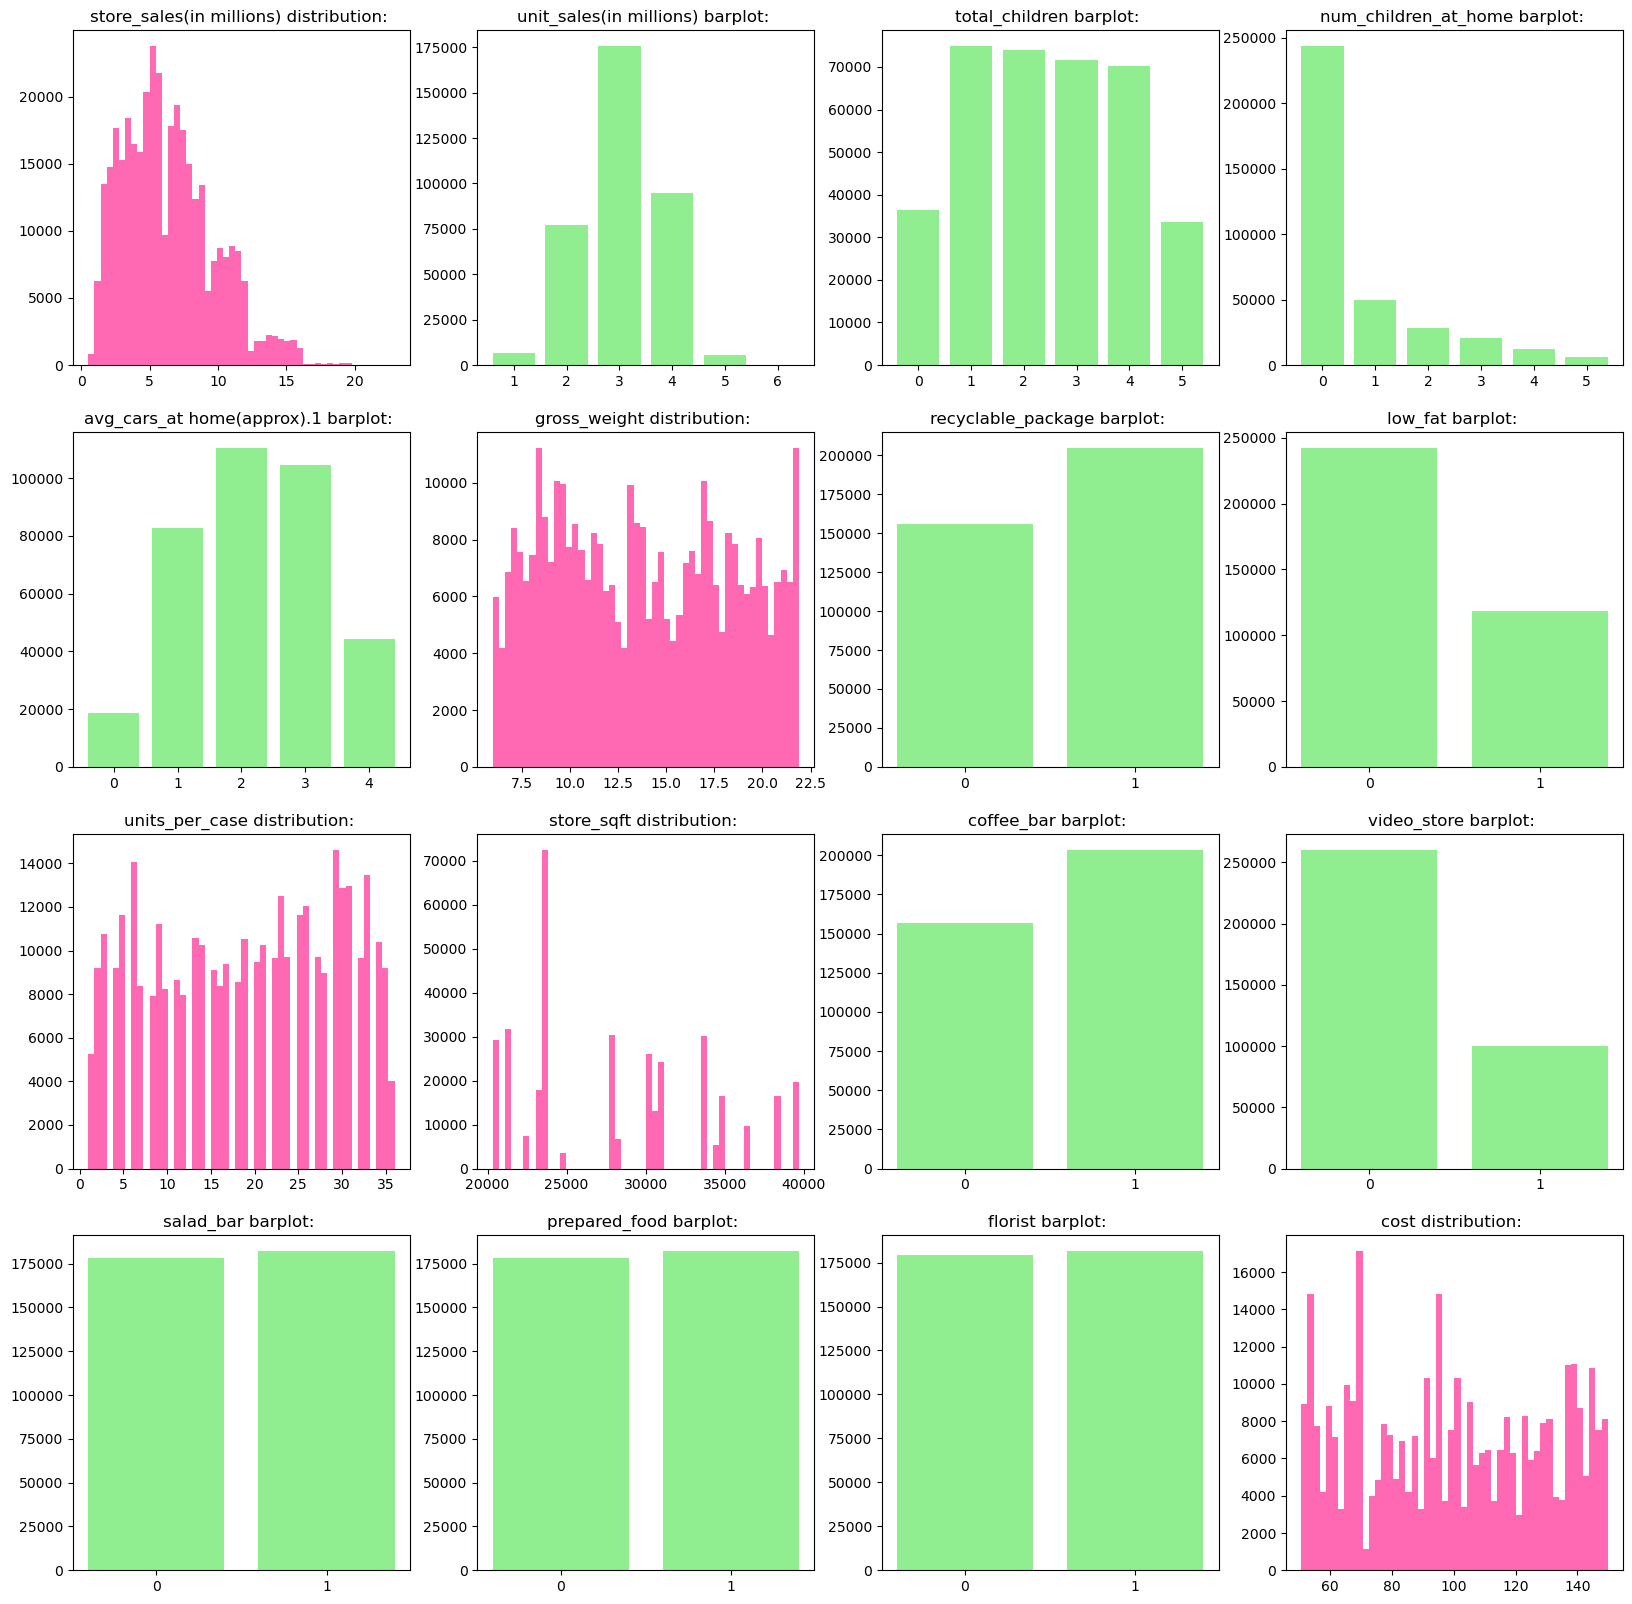

In [8]:
# Plot Histograms for Numerical variables and Bar Plots for Categorical Variables
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
ax = ax.ravel()

no_cat = 0
no_num = 0

for i in range(16):
    if df[columns[i]].nunique() <= 10:
        no_cat+=1
        ax[i].bar(df[columns[i]].value_counts().sort_index().index, df[columns[i]].value_counts().sort_index().values, color='lightgreen') 
        ax[i].set_xticks(df[columns[i]].value_counts().sort_index().index)
        ax[i].set_title(f'{columns[i]} barplot: ');
    else:
        no_num+=1
        ax[i].hist(df[columns[i]], bins=50, color = "hotpink")
        ax[i].set_title(f'{columns[i]} distribution: ');

print()
print('No. of Numerical Variables:', no_num)
print('No. of Categorical Variables:', no_cat)
print()

#### Key Insights:
We have 5 Numerical(including the target variable) and 11 Categorical Variables in this dataset.

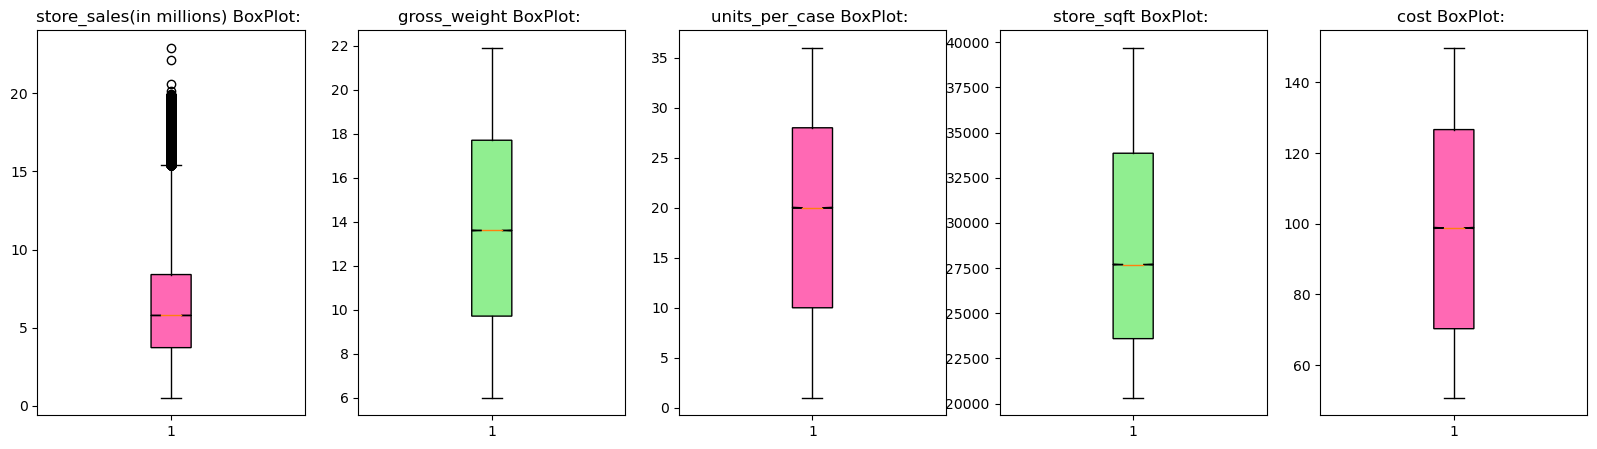

In [9]:
# BoxPlots for Numerical Variables
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
ax = ax.ravel()
i=0
colors = ['hotpink','lightgreen', 'hotpink', 'lightgreen', 'hotpink']
for c in range(16):
    if df[columns[c]].nunique() > 10:
        bplot = ax[i].boxplot(df[columns[c]], notch=True, patch_artist=True)
        ax[i].set_title(f'{columns[c]} BoxPlot: ')
        bplot['boxes'][0].set_facecolor(colors[i])
        i+=1

#### Key Insights:
There are no outliners in any of the numerical varibles except for stores_sales

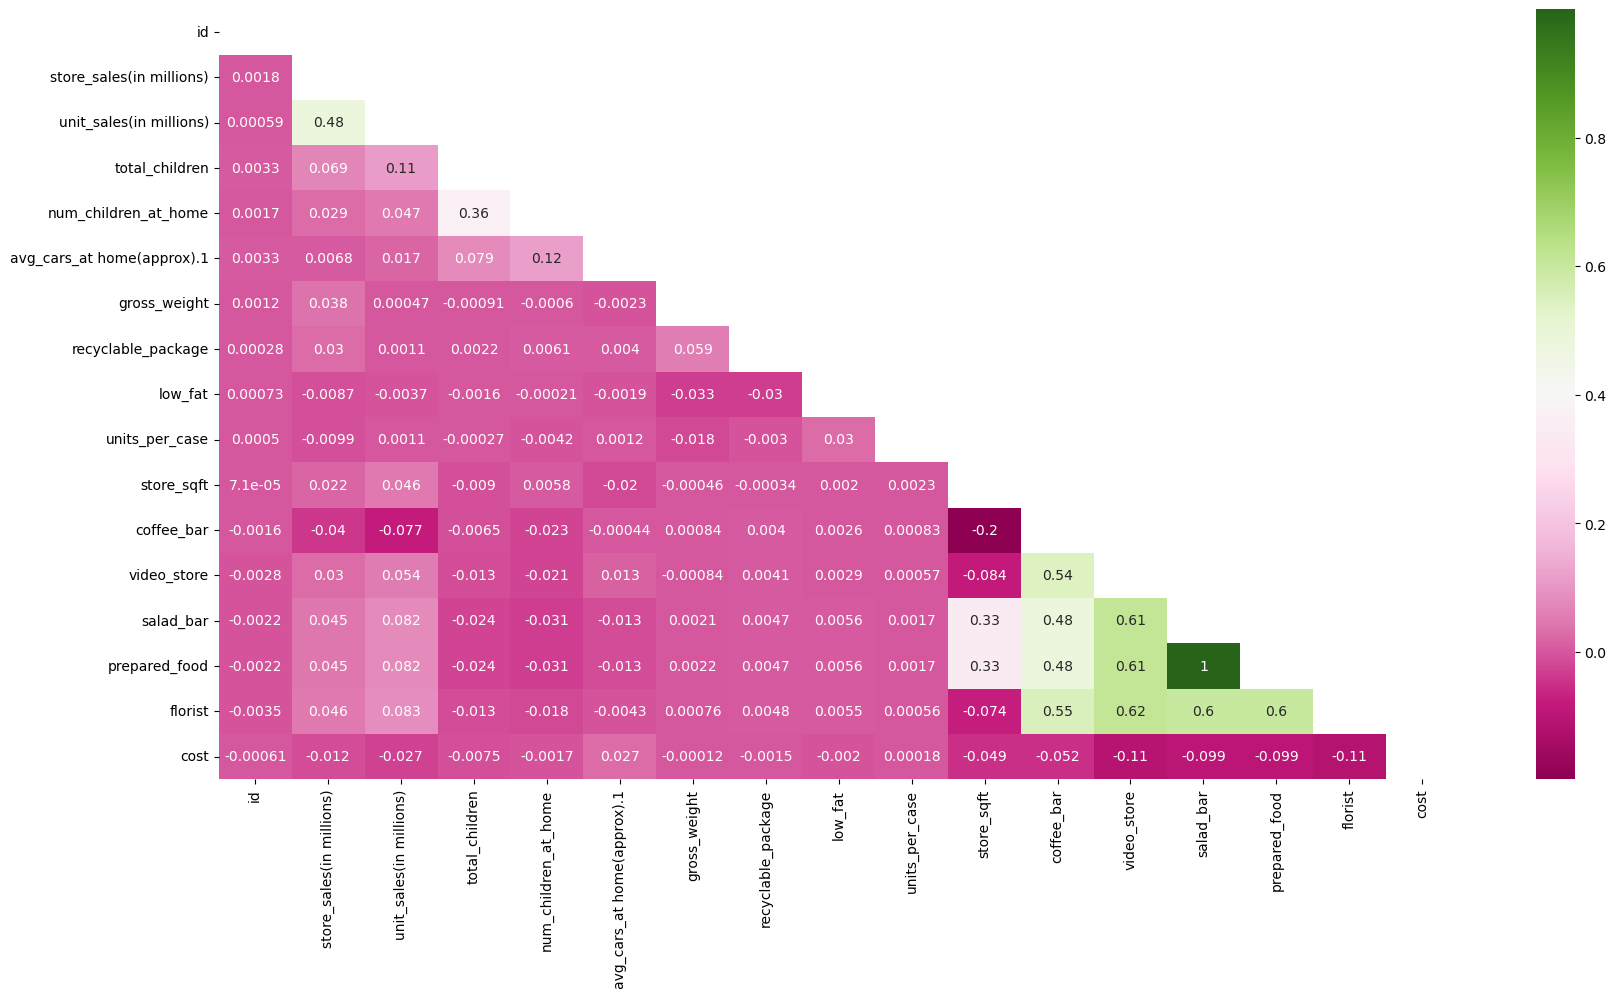

In [10]:
# The Correlation Matrix
plt.figure(figsize=(20,10))
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="PiYG");

#### Key Insights:
* The most correlated variables with the target variable (Cost) are Florist, Video_Store, Salad_Bar and Prepared_Food. 
* Moreover, salad_bar and prepared_bar have a correlation of 1.

# Adversarial Validation

Adversarial Validation is used to check the similarity between the train and test datasets in terms of feature distributions. It's very simple to perform. 

We train a binary classifier to distinguish between the train and test samples by assigning label 0 to test samples and label 1 to train samples. If the model is able to differentiate, then that means the train and test data are very different from each other and if not, then they are probably similar and the usual validation techniques should work.

In [11]:
# Most of the data preparation is taken from here:
# https://www.kaggle.com/code/konradb/adversarial-validation-and-other-scary-terms

X_train = df.drop(['id','cost'], axis=1)
y_train = df['cost'].copy()

X_test = test_df.drop(['id'], axis = 1)

# add an identifier and combine
X_train['istrain'] = 1
X_test['istrain'] = 0
X = pd.concat([X_train, X_test], axis = 0)

y = X['istrain'].copy()
X.drop('istrain', axis = 1, inplace = True)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We'll use a XGBoost Classifier
# Simple XGBoost Parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method':'gpu_hist',
    'learning_rate': 0.05, 
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'n_estimators':1000,
    'early_stopping_rounds':10
    }

In [13]:
clf = XGBClassifier(**xgb_params, seed=42)

In [14]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x0, x1 = X.iloc[train_index], X.iloc[test_index]
        y0, y1 = y.iloc[train_index], y.iloc[test_index]
        clf.fit(x0, y0, eval_set=[(x1, y1)],
                verbose=False)
        
        prval = clf.predict_proba(x1)[:,1]
        print(f'Fold {i+1} AUC Score:', roc_auc_score(y1,prval))

Fold 1 AUC Score: 0.5017366809814172
Fold 2 AUC Score: 0.49982174576007216
Fold 3 AUC Score: 0.5033632874640683
Fold 4 AUC Score: 0.5020986400036854
Fold 5 AUC Score: 0.5006986167892589


We see that the validation AUC Score for all folds above is VERY close to 0.5, i.e., it is not easy to distinguish between the train and test datasets. This means that these two datasets are statistically very similar and have similar feature distributions. So, relying on your local validation should work very well for this competition.

# XGBoost Model

In [15]:
# Log Transforming the Target Variable
df['cost'] = np.log(df['cost'])
df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,4.128585
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,4.802380
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,4.424966
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,4.201404
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,4.714114


In [16]:
# Features used to Train
# Taken from https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396508
FEATURES = [
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'low_fat',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'prepared_food',
 'florist'
]

In [17]:
# Data Preparation
X = df[FEATURES].copy()
y = df['cost'].copy()

In [18]:
# Simple XGBoost Params
xgb_params = {
    'booster': 'gbtree',
    'objective' : 'reg:squarederror',
    'eval_metric':'rmse', # We use RMSE as we log transformed the target variable
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 9999,
    'early_stopping_rounds': 200,
    'tree_method':'gpu_hist',
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'seed': 42
}

In [19]:
# 5 KFold Training 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_iteration_xgb = []
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    MODELS.append( model )
    
    fold_score = mean_squared_log_error(np.exp(y_valid), np.exp(model.predict(X_valid)), squared=False)
    print(f'Fold RMSLE Score:', fold_score)
    scores.append(fold_score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = model.feature_importances_
    
    best_iteration_xgb.append(model.best_ntree_limit)
    print('Fold Feature Importance:')
    display(fold_importance_df.sort_values(by='importance', ascending=False).head(10))
    
print()
print(f'Average Vaildation RMSLE Score:', sum(scores)/5)

#########################
### Fold 1
#########################
Fold RMSLE Score: 0.2936659670424318
Fold Feature Importance:


,feature,importance
8,florist,0.335908
4,store_sqft,0.182555
7,prepared_food,0.097826
0,total_children,0.078882
5,coffee_bar,0.078800
6,video_store,0.074245
1,num_children_at_home,0.073617
2,avg_cars_at home(approx).1,0.066173
3,low_fat,0.011994


#########################
### Fold 2
#########################
Fold RMSLE Score: 0.29207494810223456
Fold Feature Importance:


,feature,importance
8,florist,0.333230
4,store_sqft,0.181491
7,prepared_food,0.097152
6,video_store,0.084261
5,coffee_bar,0.082747
0,total_children,0.082398
1,num_children_at_home,0.066689
2,avg_cars_at home(approx).1,0.060613
3,low_fat,0.011419


#########################
### Fold 3
#########################
Fold RMSLE Score: 0.2932783819529441
Fold Feature Importance:


,feature,importance
8,florist,0.351618
4,store_sqft,0.180024
5,coffee_bar,0.085204
6,video_store,0.084013
7,prepared_food,0.075878
0,total_children,0.074707
1,num_children_at_home,0.073196
2,avg_cars_at home(approx).1,0.065201
3,low_fat,0.010159


#########################
### Fold 4
#########################
Fold RMSLE Score: 0.2937368822241054
Fold Feature Importance:


,feature,importance
8,florist,0.324000
4,store_sqft,0.179642
5,coffee_bar,0.090385
6,video_store,0.087266
7,prepared_food,0.085980
0,total_children,0.083522
1,num_children_at_home,0.070080
2,avg_cars_at home(approx).1,0.068279
3,low_fat,0.010845


#########################
### Fold 5
#########################
Fold RMSLE Score: 0.29440006043688405
Fold Feature Importance:


,feature,importance
8,florist,0.343222
4,store_sqft,0.181752
0,total_children,0.082512
5,coffee_bar,0.081262
1,num_children_at_home,0.078090
6,video_store,0.077776
7,prepared_food,0.072715
2,avg_cars_at home(approx).1,0.070715
3,low_fat,0.011955



Average Vaildation RMSLE Score: 0.29343124795171993


## Submission

In [20]:
submission = pd.DataFrame(index = test_df.index.unique())
submission['id'] = test_df.id.unique()

In [21]:
test_df = test_df[FEATURES]

In [22]:
for i in range(5):
    submission[f'cost{i}'] = MODELS[i].predict(test_df)
submission['cost'] = np.exp((submission.cost0 + submission.cost1 + submission.cost2 + submission.cost3 + submission.cost4) / 5)
submission = submission[['id','cost']]

In [23]:
submission.head()

,id,cost
0,360336,91.636734
1,360337,92.674171
2,360338,93.795517
3,360339,98.665405
4,360340,77.304718


In [24]:
submission.to_csv('submission.csv', index=False)

You can even try to use the original dataset from which this synthetic data is generated to get more data see if it improves your model. You can find the dataset [here][0].

I hope this notebook will help you in better understanding this competition and making amazing ML Models.
#### Happy Modelling!!

[0]: https://www.kaggle.com/datasets/gauravduttakiit/media-campaign-cost-prediction